### Simulation

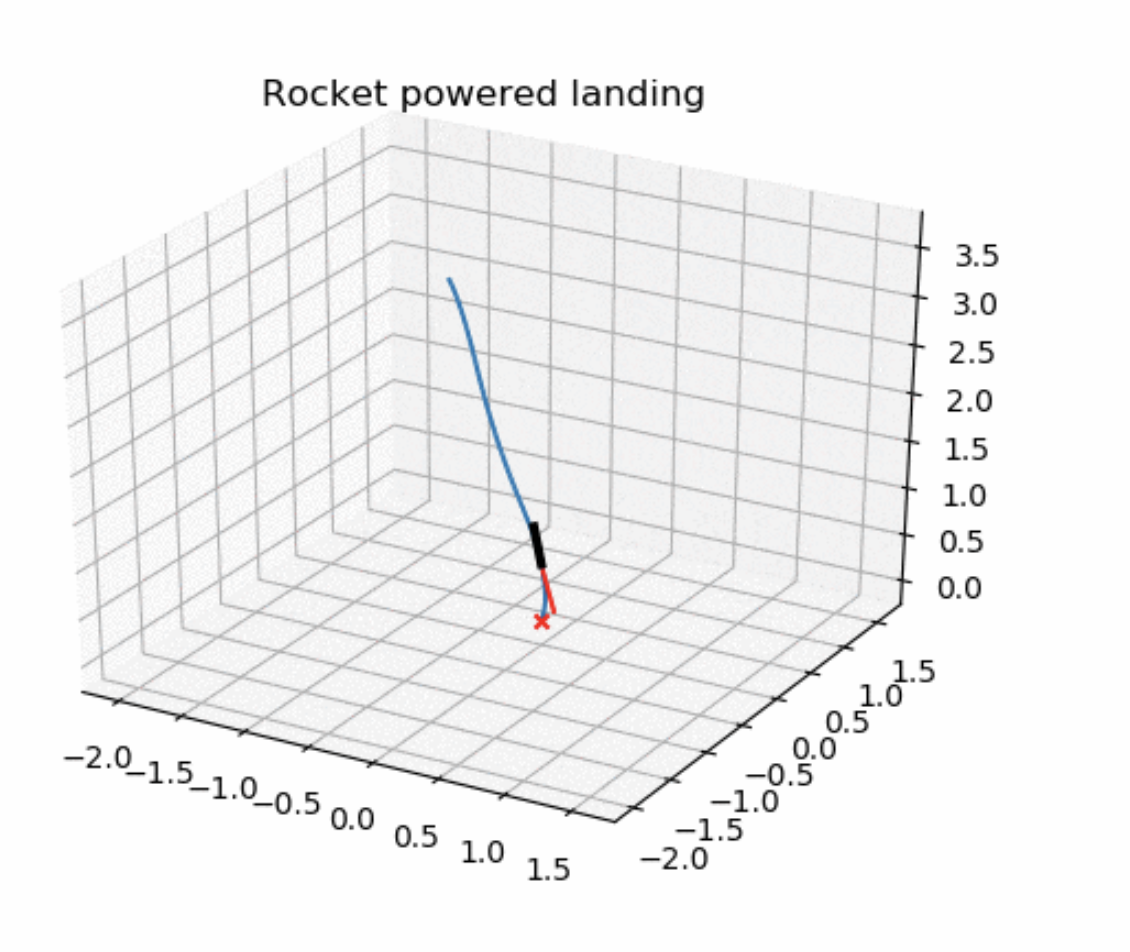

In [4]:
from IPython.display import Image
Image(filename="figure.png",width=600)

![gif](https://github.com/AtsushiSakai/PythonRobotics/raw/master/AerialNavigation/rocket_powered_landing/animation.gif)

### Equation generation

In [32]:
import sympy as sp
import numpy as np
from IPython.display import display
sp.init_printing(use_latex='mathjax')

In [43]:
# parameters
# Angular moment of inertia
J_B = 1e-2 * np.diag([1., 1., 1.])

# Gravity
g_I = np.array((-1, 0., 0.))

# Fuel consumption
alpha_m = 0.01

# Vector from thrust point to CoM
r_T_B = np.array([-1e-2, 0., 0.])


def dir_cosine(q):
        return np.matrix([
            [1 - 2 * (q[2] ** 2 + q[3] ** 2), 2 * (q[1] * q[2] +
                                                   q[0] * q[3]), 2 * (q[1] * q[3] - q[0] * q[2])],
            [2 * (q[1] * q[2] - q[0] * q[3]), 1 - 2 *
             (q[1] ** 2 + q[3] ** 2), 2 * (q[2] * q[3] + q[0] * q[1])],
            [2 * (q[1] * q[3] + q[0] * q[2]), 2 * (q[2] * q[3] -
                                                   q[0] * q[1]), 1 - 2 * (q[1] ** 2 + q[2] ** 2)]
        ])

def omega(w):
        return np.matrix([
            [0, -w[0], -w[1], -w[2]],
            [w[0], 0, w[2], -w[1]],
            [w[1], -w[2], 0, w[0]],
            [w[2], w[1], -w[0], 0],
        ])

def skew(v):
    return np.matrix([
            [0, -v[2], v[1]],
            [v[2], 0, -v[0]],
            [-v[1], v[0], 0]
        ])



In [38]:
f = sp.zeros(14, 1)

x = sp.Matrix(sp.symbols(
    'm rx ry rz vx vy vz q0 q1 q2 q3 wx wy wz', real=True))
u = sp.Matrix(sp.symbols('ux uy uz', real=True))

g_I = sp.Matrix(g_I)
r_T_B = sp.Matrix(r_T_B)
J_B = sp.Matrix(J_B)

C_B_I = dir_cosine(x[7:11, 0])
C_I_B = C_B_I.transpose()

f[0, 0] = - alpha_m * u.norm()
f[1:4, 0] = x[4:7, 0]
f[4:7, 0] = 1 / x[0, 0] * C_I_B * u + g_I
f[7:11, 0] = 1 / 2 * omega(x[11:14, 0]) * x[7: 11, 0]
f[11:14, 0] = J_B ** -1 * \
    (skew(r_T_B) * u - skew(x[11:14, 0]) * J_B * x[11:14, 0])


In [39]:
display(sp.simplify(f)) # f

⎡                                  _________________                          
⎢                                 ╱   2     2     2                           
⎢                         -0.01⋅╲╱  ux  + uy  + uz                            
⎢                                                                             
⎢                                     vx                                      
⎢                                                                             
⎢                                     vy                                      
⎢                                                                             
⎢                                     vz                                      
⎢                                                                             
⎢            ⎛    2       2    ⎞                                              
⎢-1.0⋅m - ux⋅⎝2⋅q₂  + 2⋅q₃  - 1⎠ - 2⋅uy⋅(q₀⋅q₃ - q₁⋅q₂) + 2⋅uz⋅(q₀⋅q₂ + q₁⋅q₃)
⎢───────────────────────────────────────────────────

In [40]:
sp.simplify(f.jacobian(x)) # A 

⎡                                  0                                    0  0  
⎢                                                                             
⎢                                  0                                    0  0  
⎢                                                                             
⎢                                  0                                    0  0  
⎢                                                                             
⎢                                  0                                    0  0  
⎢                                                                             
⎢   ⎛    2       2    ⎞                                                       
⎢ux⋅⎝2⋅q₂  + 2⋅q₃  - 1⎠ + 2⋅uy⋅(q₀⋅q₃ - q₁⋅q₂) - 2⋅uz⋅(q₀⋅q₂ + q₁⋅q₃)         
⎢────────────────────────────────────────────────────────────────────   0  0  
⎢                                  2                                          
⎢                                 m                 

In [42]:
sp.simplify(f.jacobian(u)) # B

⎡     -0.01⋅ux              -0.01⋅uy              -0.01⋅uz       ⎤
⎢────────────────────  ────────────────────  ────────────────────⎥
⎢   _________________     _________________     _________________⎥
⎢  ╱   2     2     2     ╱   2     2     2     ╱   2     2     2 ⎥
⎢╲╱  ux  + uy  + uz    ╲╱  ux  + uy  + uz    ╲╱  ux  + uy  + uz  ⎥
⎢                                                                ⎥
⎢         0                     0                     0          ⎥
⎢                                                                ⎥
⎢         0                     0                     0          ⎥
⎢                                                                ⎥
⎢         0                     0                     0          ⎥
⎢                                                                ⎥
⎢      2       2                                                 ⎥
⎢- 2⋅q₂  - 2⋅q₃  + 1    2⋅(-q₀⋅q₃ + q₁⋅q₂)    2⋅(q₀⋅q₂ + q₁⋅q₃)  ⎥
⎢───────────────────    ──────────────────    ────────────────

### Ref

- Python implementation of 'Successive Convexification for 6-DoF Mars Rocket Powered Landing with Free-Final-Time' paper
by Michael Szmuk and Behçet Açıkmeşe.

- inspired by EmbersArc/SuccessiveConvexificationFreeFinalTime: Implementation of "Successive Convexification for 6-DoF Mars Rocket Powered Landing with Free-Final-Time" https://github.com/EmbersArc/SuccessiveConvexificationFreeFinalTime

